# Dynamic Programming
A method for solving complex problems
By breaking them down into subproblems. \
Solve the subproblems -> Combine solutions to subproblems

#### Bellmann Optimality equation
$$
v_*(s) = \max_a \mathbb{E}[R_{t+1} + \gamma v_*(S_{t+1}) \mid S_t = s, A_t = a]\\
= \max_a \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma v_*(s') \right]
$$
$$
q_*(s, a) = \mathbb{E} \left[ R_{t+1} + \gamma \max_{a'} q_*(S_{t+1}, a') \mid S_t = s, A_t = a \right]\\
= \sum_{s', r} p(s', r \mid s, a) \left[ r + \gamma \max_{a'} q_*(s', a') \right]
$$

Because of the max operator, the optimality equations are non linear. So you cannot simply rearrange the terms to factor out $v_*$ and invert a matrix. There is no closed-form linear algebraic solution for the optimal policy.

*DP's Solution:* Dynamic Programming handles this by turning the problem into an iterative loop: "Guess, apply max, update, repeat" until it converges.


## Iterative Policy Evaluation
![alt text](images/Iterative%20policy%20evaluation%20algo.png)

### Example: Grid World

![grid world example](images/grid%20word%20example.png)

#### Problem Setup

**Nonterminal States:** $S = \{1, 2, \ldots, 14\}$

**Actions:** $A = \{\text{up, down, right, left}\}$
- Actions deterministically cause state transitions
- Actions that would take the agent off the grid leave the state unchanged
- Example transitions: $p(6, 1 \mid 5, \text{right}) = 1$, $p(7, 1 \mid 7, \text{right}) = 1$, $p(10, r \mid 5, \text{right}) = 0$ for all $r \in \mathbb{R}$

**Task Type:** Undiscounted, episodic task

**Reward Structure:**
- Reward = $-1$ on all transitions until the terminal state is reached
- Terminal state is shaded in the figure (shown in two places but formally one state)
- Expected reward function: $r(s, a, s') = -1$ for all states $s, s'$ and actions $a$

#### Policy Evaluation

The agent follows an **equiprobable random policy** (all actions equally likely).

$$\pi(u|.) = \pi(d|.) = \pi(r|.) = \pi(l|.) = 0.25$$

In [2]:
# Example 4.1 Solution
import numpy as np
import matplotlib.pyplot as plt

# Grid World Setup
grid_size = 4
num_states = grid_size * grid_size
num_actions = 4
gamma = 1.0  # Undiscounted
theta = 1e-3

# Initialize value function
V = np.zeros(num_states)
V[0] = V[15] = 0  # Terminal states

def get_next_state(s, a, grid_size=4):
    """Get next state given state s and action a (0=up, 1=down, 2=left, 3=right)"""
    if s in [0, 15]:  # Terminal states
        return s
    row, col = divmod(s, grid_size)
    if a == 0:      row -= 1  # up
    elif a == 1:    row += 1  # down
    elif a == 2:    col -= 1  # left
    elif a == 3:    col += 1  # right
    
    if not (0 <= row < grid_size and 0 <= col < grid_size):
        return s  # Stay in place if move goes outside grid
    return row * grid_size + col

# Iterative Policy Evaluation
iteration = 0
while True:
    delta = 0
    for s in range(num_states):
        if s in [0, 15]:  # Skip terminal states
            continue
        v = V[s]
        # V(s) ← Σ_a π(a|s) Σ_s' p(s'|s,a)[r + γV(s')]
        V[s] = sum(0.25 * ((-1) + gamma * V[get_next_state(s, a)]) 
                   for a in range(num_actions))
        delta = max(delta, abs(v - V[s]))
    
    iteration += 1
    if delta < theta:
        break

print(f"Converged in {iteration} iterations")
print(f"\nState Values:\n{V.reshape(4, 4).round(2)}")

# # Visualize
# plt.imshow(V.reshape(4, 4), cmap='RdYlGn')
# plt.colorbar(label='Value')
# plt.title('State Value Function - Equiprobable Random Policy')
# for i in range(4):
#     for j in range(4):
#         plt.text(j, i, f'{V[i*4+j]:.1f}', ha='center', va='center')
# plt.show()

Converged in 88 iterations

State Values:
[[  0.   -13.99 -19.99 -21.99]
 [-13.99 -17.99 -19.99 -19.99]
 [-19.99 -19.99 -17.99 -13.99]
 [-21.99 -19.99 -13.99   0.  ]]


## Policy Iteration
![alt text](images/Policy%20iteration%20algo.png)


Policy converged in 3 iterations

Optimal Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]

Optimal Policy:
T ← ← ↓ 
↑ ↑ ↑ ↓ 
↑ ↑ ↓ ↓ 
↑ → → T 


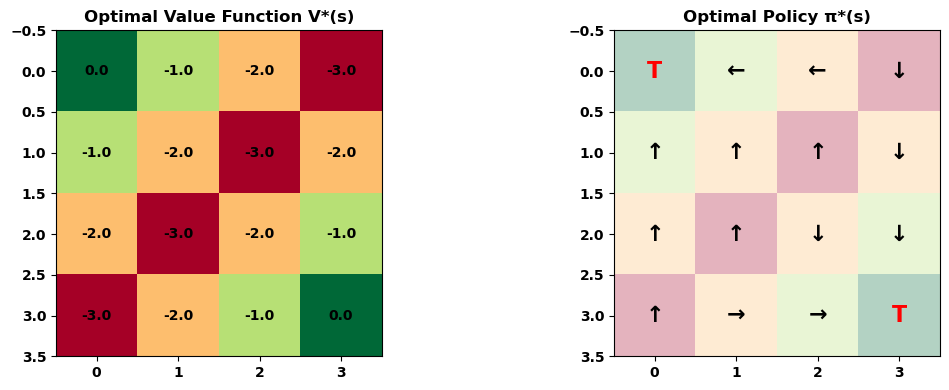

In [6]:
# Policy Iteration Algorithm
# Initialize
V = np.zeros(num_states)
policy = np.ones((num_states, num_actions)) / num_actions  # Equiprobable random policy
theta = 1e-4

policy_iteration_count = 0
while True:
    # Policy Evaluation
    while True:
        delta = 0
        for s in range(num_states):
            if s in [0, 15]:  # Terminal states
                continue
            v = V[s]
            # V(s) ← Σ_a π(a|s) Σ_s' p(s'|s,a)[r + γV(s')]
            V[s] = sum(policy[s, a] * ((-1) + gamma * V[get_next_state(s, a)]) 
                      for a in range(num_actions))
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    
    # Policy Improvement
    policy_stable = True
    for s in range(num_states):
        if s in [0, 15]:
            continue
        old_action = np.argmax(policy[s])
        # π(s) ← argmax_a Σ_s' p(s'|s,a)[r + γV(s')]
        action_values = np.array([(-1) + gamma * V[get_next_state(s, a)] 
                                 for a in range(num_actions)])
        best_action = np.argmax(action_values)
        policy[s] = 0
        policy[s, best_action] = 1
        if old_action != best_action:
            policy_stable = False
    
    policy_iteration_count += 1
    if policy_stable:
        break

action_names = {0: '↑', 1: '↓', 2: '←', 3: '→'}
print(f"\nPolicy converged in {policy_iteration_count} iterations")
print(f"\nOptimal Value Function:\n{V.reshape(4, 4).round(2)}")
print(f"\nOptimal Policy:")
for i in range(4):
    for j in range(4):
        s = i * 4 + j
        if s in [0, 15]:
            print('T', end=' ')
        else:
            print(action_names[np.argmax(policy[s])], end=' ')
    print()

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(V.reshape(4, 4), cmap='RdYlGn')
ax1.set_title('Optimal Value Function V*(s)')
for i in range(4):
    for j in range(4):
        ax1.text(j, i, f'{V[i*4+j]:.1f}', ha='center', va='center')

ax2.imshow(V.reshape(4, 4), cmap='RdYlGn', alpha=0.3)
ax2.set_title('Optimal Policy π*(s)')
for i in range(4):
    for j in range(4):
        s = i * 4 + j
        if s in [0, 15]:
            ax2.text(j, i, 'T', ha='center', va='center', fontsize=16, color='red', weight='bold')
        else:
            ax2.text(j, i, action_names[np.argmax(policy[s])], ha='center', va='center', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

## Value Iteration
![alt text](images/Value_iteration_algo.png)

Value Iteration converged in 4 iterations

Optimal Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]

Optimal Policy:
T ← ← ↓ 
↑ ↑ ↑ ↓ 
↑ ↑ ↓ ↓ 
↑ → → T 


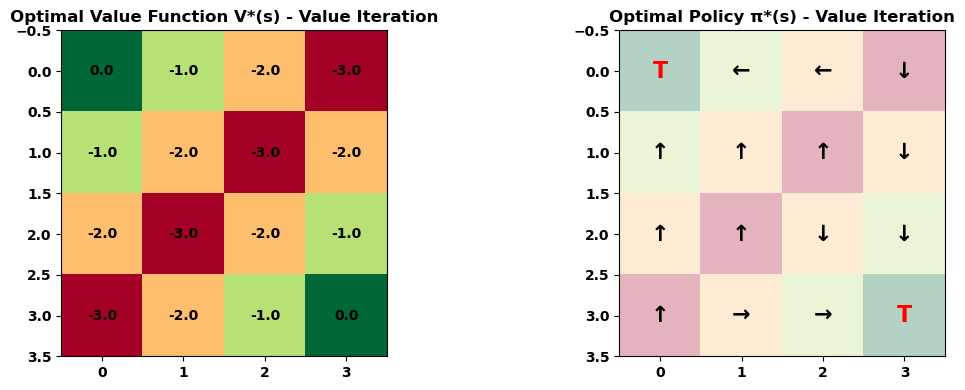

In [3]:
# Value Iteration Algorithm
V = np.zeros(num_states)
V[0] = V[15] = 0  # Terminal states
policy = np.zeros(num_states, dtype=int)
theta = 1e-4

iteration = 0
while True:
    delta = 0
    for s in range(num_states):
        if s in [0, 15]:  # Terminal states
            continue
        v = V[s]
        # V(s) ← max_a Σ_s' p(s'|s,a)[r + γV(s')]
        action_values = np.array([(-1) + gamma * V[get_next_state(s, a)] 
                                 for a in range(num_actions)])
        V[s] = np.max(action_values)
        delta = max(delta, abs(v - V[s]))
    
    iteration += 1
    if delta < theta:
        break

# Extract optimal policy from converged value function
for s in range(num_states):
    if s in [0, 15]:
        continue
    action_values = np.array([(-1) + gamma * V[get_next_state(s, a)] 
                             for a in range(num_actions)])
    policy[s] = np.argmax(action_values)

action_names = {0: '↑', 1: '↓', 2: '←', 3: '→'}
print(f"Value Iteration converged in {iteration} iterations")
print(f"\nOptimal Value Function:\n{V.reshape(4, 4).round(2)}")
print(f"\nOptimal Policy:")
for i in range(4):
    for j in range(4):
        s = i * 4 + j
        if s in [0, 15]:
            print('T', end=' ')
        else:
            print(action_names[policy[s]], end=' ')
    print()

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(V.reshape(4, 4), cmap='RdYlGn')
ax1.set_title('Optimal Value Function V*(s) - Value Iteration')
for i in range(4):
    for j in range(4):
        ax1.text(j, i, f'{V[i*4+j]:.1f}', ha='center', va='center')

ax2.imshow(V.reshape(4, 4), cmap='RdYlGn', alpha=0.3)
ax2.set_title('Optimal Policy π*(s) - Value Iteration')
for i in range(4):
    for j in range(4):
        s = i * 4 + j
        if s in [0, 15]:
            ax2.text(j, i, 'T', ha='center', va='center', fontsize=16, color='red', weight='bold')
        else:
            ax2.text(j, i, action_names[policy[s]], ha='center', va='center', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()
